In [605]:
import requests
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as mplt
import plotly.express as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_digits
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn'

In [606]:
# Drill-Funktionen importieren
%run drill.py

In [607]:
def encode_cyclical(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [608]:
def create_plot(data):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data['timestamp'], 
                             y=data['co2_ppm'], 
                             mode='markers',
                             marker=dict(
                                 color=(
                                    (data['presence'] == 0)).astype('int'),
                                    colorscale=[[0, 'yellow'], [1, 'blue']])))
    return fig

In [609]:
#df = get_PIR_data()
#df.to_json('data.json')

In [610]:
df = pd.read_json('data.json') 

In [611]:
plt.scatter(df, x='timestamp', y='co2_ppm', color='presence')

In [612]:
df_test = df

df_nov = df.loc[(df['timestamp'] < pd.to_datetime(1636722000, unit='s', origin='unix')) &
                (df['timestamp'] > pd.to_datetime(1634562000, unit='s', origin='unix'))]

df_nov.reset_index(drop=True, inplace=True)
# alle zwischen 18.10. und 22.11. entfernen
df_test = df.drop(df[(df['timestamp'] > pd.to_datetime(1634518800, unit='s', origin='unix')) & 
                    (df['timestamp'] < pd.to_datetime(1637586000, unit='s', origin='unix'))].index)


# timestamp etwas leichter zu verarbeiten, wenn als Integer gespeichert
df_test = df_test.assign(hoursMinutesSeconds=lambda d: (d['timestamp'].dt.hour.astype('int') * 10000 + 
                                                        d['timestamp'].dt.minute.astype('int') * 100 + 
                                                       d['timestamp'].dt.second.astype('int')))

df_test['hour_sin'] = np.sin(2 * np.pi * df_test['hoursMinutesSeconds']/235959.0)
df_test['hour_cos'] = np.cos(2 * np.pi * df_test['hoursMinutesSeconds']/235959.0)

df_nov = df_nov.assign(hoursMinutesSeconds=lambda d: (d['timestamp'].dt.hour.astype('int') * 10000 + 
                                                        d['timestamp'].dt.minute.astype('int') * 100 + 
                                                       d['timestamp'].dt.second.astype('int')))

df_nov['hour_sin'] = np.sin(2 * np.pi * df_nov['hoursMinutesSeconds']/235959.0)
df_nov['hour_cos'] = np.cos(2 * np.pi * df_nov['hoursMinutesSeconds']/235959.0)

In [613]:
plt.scatter(df_test, x='timestamp', y='co2_ppm', color='presence')

In [614]:
# erhoeht sich die Genauigkeit, wenn Datenset ausgeglichener ist?
# Idee bei ca. 8 Stunden Anwesenheit:
# Entferne 8 Nachtstunden von 22:00-05:00, 
# sodass von 24 stunden 8 Anwesenheits-Stunden und 8 Abwesenheits-Stunden uebrig bleiben
df_test.drop(df_test[(df_test['hoursMinutesSeconds'] < 50000) |
                     (df_test['hoursMinutesSeconds'] > 220000)].index, inplace=True)

df_nov.drop(df_nov[(df_nov['hoursMinutesSeconds'] < 50000) |
                     (df_nov['hoursMinutesSeconds'] > 220000)].index, inplace=True)


In [615]:
plt.scatter(df_nov, x='timestamp', y='co2_ppm', color='presence')

In [616]:
# Template für mehrere Plots in einem Graphen
#fig = create_plot(df_test)
#df_test['co2_ppmShifted'] = df_test['co2_ppm'].shift(12)
#fig.add_trace(go.Scatter(x=df_test['timestamp'], 
#                             y=df_test['co2_ppmShifted'], 
#                             mode='lines',
#                             line=dict(width=2),
#                             marker=dict(
#                                 color=(
#                                    (df_test['presence'] == 0)).astype('int'),
#                                    colorscale=[[0, 'green'], [1, 'red']])))

#fig.show()
#plt.scatter(df_test, x='timestamp', y='co2_ppm', color='presence')

In [617]:
# Steigungen mit Abstaenden 5, 30 und 60 Minuten einfuegen
df_test['co2_ppm_deltaOne'] = df_test['co2_ppm'] - df_test.shift(1)['co2_ppm']
df_test['co2_ppm_deltaSix'] = df_test['co2_ppm'] - df_test.shift(6)['co2_ppm']
df_test['co2_ppm_deltaTwelve'] = df_test['co2_ppm'] - df_test.shift(12)['co2_ppm']
#df_test['co2_ppm_deltaMinusOne'] = df_test.shift(-1)['co2_ppm'] - df_test['co2_ppm']
#df_test['co2_ppm_deltaMinusSix'] = df_test.shift(-6)['co2_ppm'] - df_test['co2_ppm']
#df_test['co2_ppm_deltaMinusTwelve'] = df_test.shift(-12)['co2_ppm'] - df_test['co2_ppm']

# Falsche November-Daten ebenfalls mit Delta versehen
df_nov['co2_ppm_deltaOne'] = df_nov['co2_ppm'] - df_nov.shift(1)['co2_ppm']
df_nov['co2_ppm_deltaSix'] = df_nov['co2_ppm'] - df_nov.shift(6)['co2_ppm']
df_nov['co2_ppm_deltaTwelve'] = df_nov['co2_ppm'] - df_nov.shift(12)['co2_ppm']

In [618]:
# Wochentag einfuegen
# verringert Genauigkeit, weil wahrscheinlich zu "verlaesslich"

#df_test['dayOfWeek'] = df['timestamp'].dt.dayofweek
#df_test = df_test.drop(df_test[df_test.dayOfWeek > 4].index)

In [619]:
# Ausreisser mit Interquartile Range (IQR) und Tukey's Method loeschen
# Idee: Fenster wird an fast allen Tagen ab ca. 1200-1300 ppm geoeffnet
# -> was veraendert sich, wenn die Werte darüber entfernt werden und das Datenset so "geglaettet" wird?
# Erhoeht Genauigkeit um ca. 2%
x = df_test['co2_ppm']
q1 = np.percentile(x, 12)
q3 = np.percentile(x, 88)
iqr = q3 - q1
floor = q1 - 1.5*iqr
ceiling = q3 + 1.5*iqr
outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
outlier_values = list(x[outlier_indices])
print(outlier_values)

[]


In [620]:
df_test = df_test.drop(index=outlier_indices)

In [621]:
# timestamp, presence, temperatur und humidity entfernen
# temp/humid erhoehen Genauigkeit deutlich, da relativ unverlaesslich -> von zu vielen aeusseren Faktoren abhaengig
df_test = df_test.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df_timestamp = df_test['timestamp']
y_presence = df_test['presence']
X_presence = df_test.drop(['timestamp', 'hoursMinutesSeconds', 'presence', 'temperature_celsius', 'relative_humidity_percent'], axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_presence, y_presence, test_size=0.2, random_state=1, shuffle=False)

In [622]:
# shift des trainings-sets um 5 minuten in die Vergangenheit
# -> Test ob Model auch in die Zukunft Erwartungen treffen kann
#ytrain = ytrain.shift(-6)
#ytrain.dropna(axis=0, how='any', inplace=False)
#ytrain = ytrain.replace(np.nan, 0)

In [623]:
# Random Forest Classification
model = RandomForestClassifier(n_estimators=250)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
#print(metrics.classification_report(ypred, ytest))
accuracy_score(ytest, ypred)

0.9316823228010248

[Text(0.5, 0, 'Importance'), Text(0, 0.5, 'Feature')]

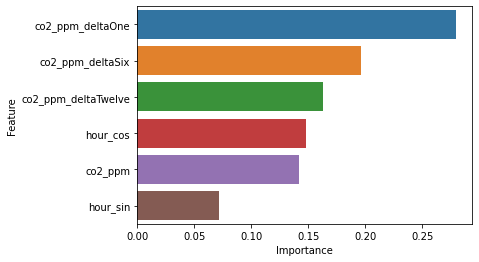

In [624]:
# plot feature-importance
feature_imp = pd.Series(model.feature_importances_,index=Xtrain.columns).sort_values(ascending=False)
# Creating a bar plot
ax = sns.barplot(x=feature_imp, y=feature_imp.index)
ax.set(xlabel='Importance', ylabel='Feature')

In [625]:
# Random Forest Regression
model = RandomForestRegressor(n_estimators=250)
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

In [626]:
df_valid = Xtest.copy()
df_valid['timestamp'] = df_timestamp
df_valid['prediction'] = ypred
df_valid['co2_ppm'] = df_test['co2_ppm']
df_valid['presence'] = ytest

plt.scatter(df_valid, x='timestamp', y='co2_ppm', color='prediction')

In [627]:
# falsche Werte im November korrigieren
df_nov.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df_timestamp_nov = df_nov['timestamp']
df_nov.drop(['timestamp', 'hoursMinutesSeconds', 'presence', 'temperature_celsius', 'relative_humidity_percent'], axis=1, inplace=True)
ypred_nov = model.predict(df_nov)


In [634]:
df_valid_nov = df_nov.copy()
df_valid_nov['timestamp'] = df_timestamp_nov
df_valid_nov['prediction'] = ypred_nov
df_valid_nov['co2_ppm'] = df_nov['co2_ppm']

df_valid_nov.loc[df_valid_nov['prediction'] >= 0.5, 'prediction'] = 1
df_valid_nov.loc[df_valid_nov['prediction'] < 0.5, 'prediction'] = 0


In [635]:
plt.scatter(df_valid_nov, x='timestamp', y='co2_ppm', color='prediction')